# 보험료 예측

# 선형회귀 모델 작성, 예측, 평가

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
premium_df = pd.read_csv('premium.csv')
premium_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
premium_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1333 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


<Axes: xlabel='bmi', ylabel='Count'>

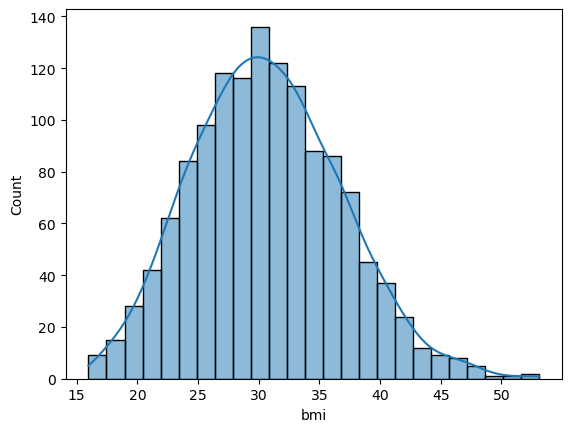

In [5]:
import seaborn as sns
sns.histplot(premium_df['bmi'], kde=True)

In [6]:
premium_df['bmi'] = premium_df['bmi'].fillna(premium_df['bmi'].mean())

In [7]:
from sklearn.preprocessing import LabelEncoder

le_sex = LabelEncoder()
le_smoker = LabelEncoder()

premium_df['sex'] = le_sex.fit_transform(premium_df['sex'])
premium_df['smoker'] = le_smoker.fit_transform(premium_df['smoker'])

premium_df = pd.get_dummies(premium_df, columns=['region'], drop_first=True)

In [8]:
X = premium_df.drop('charges', axis=1).values
y = premium_df['charges'].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

lr_mse = mean_squared_error(y_test, lr_pred)
lr_rmse = np.sqrt(lr_mse)
lr_r2 = r2_score(y_test, lr_pred)

print(f'lr의 MSE: {lr_mse}, RMSE: {lr_rmse}, R2: {lr_r2}')

lr의 MSE: 33775854.0455305, RMSE: 5811.699755280764, R2: 0.7696435568519837


In [11]:
from sklearn.model_selection import cross_val_score
neg_mse_scores = cross_val_score(lr, X, y, scoring='neg_mean_squared_error', cv=5)
rmse = np.sqrt(neg_mse_scores * -1)
r2_scores = cross_val_score(lr, X, y, scoring='r2', cv=5)

print(f'lr의 RMSE: {np.mean(rmse)}, R2: {np.mean(r2_scores)}')

lr의 RMSE: 6085.754599270111, R2: 0.745781545550763


In [12]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=6,
    random_state=42
    )
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_pred)

print(f'rf의 MSE: {rf_mse}, RMSE: {rf_rmse}, R2: {rf_r2}')

rf의 MSE: 18569044.489695415, RMSE: 4309.181417589124, R2: 0.8733563025367957


In [13]:
neg_mse_scores = cross_val_score(rf, X, y, scoring='neg_mean_squared_error', cv=5)
rmse = np.sqrt(neg_mse_scores * -1)
r2_scores = cross_val_score(rf, X, y, scoring='r2', cv=5)

print(f'rf의 RMSE: {np.mean(rmse)}, R2: {np.mean(r2_scores)}')

rf의 RMSE: 4547.115583938444, R2: 0.856732576325693


In [14]:
from sklearn.model_selection import GridSearchCV

# params = {
#     'n_estimators': [200, 300, 400],
#     'max_depth': [None, 4, 5, 6],
#     'min_samples_split': [5, 9, 10, 12],
#     'min_samples_leaf': [4, 5, 6],
# }

# rf = RandomForestRegressor(random_state=42)
# grid_search = GridSearchCV(rf, params, scoring='neg_mean_squared_error', cv=5)
# grid_search.fit(X, y)

# print(grid_search.best_params_)

# 다항회귀 비교

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [16]:
results = []

for degree in range(1, 6):
    lr_model_poly = Pipeline([
    ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
    ('linear', LinearRegression())
    ])
    lr_model_poly.fit(X_train, y_train)
    lr_pred_poly = lr_model_poly.predict(X_test)
    mse = mean_squared_error(y_test, lr_pred_poly)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, lr_pred_poly)

    results.append({'degree':degree, 'MSE':mse, 'RMSE':rmse, 'R2':r2})

result_df = pd.DataFrame(results)
result_df

,degree,MSE,RMSE,R2
0,1,3.377585e+07,5811.699755,0.769644
1,2,2.068917e+07,4548.534768,0.858897
2,3,2.352564e+07,4850.323876,0.839552
3,4,4.343805e+07,6590.754811,0.703746
4,5,4.043791e+08,20109.180368,-1.757927


In [23]:
lr_model_poly = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('linear', LinearRegression())
    ])

lr_model_poly.fit(X_train, y_train)
lr_pred_poly = lr_model_poly.predict(X_test)
mse = mean_squared_error(y_test, lr_pred_poly)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, lr_pred_poly)

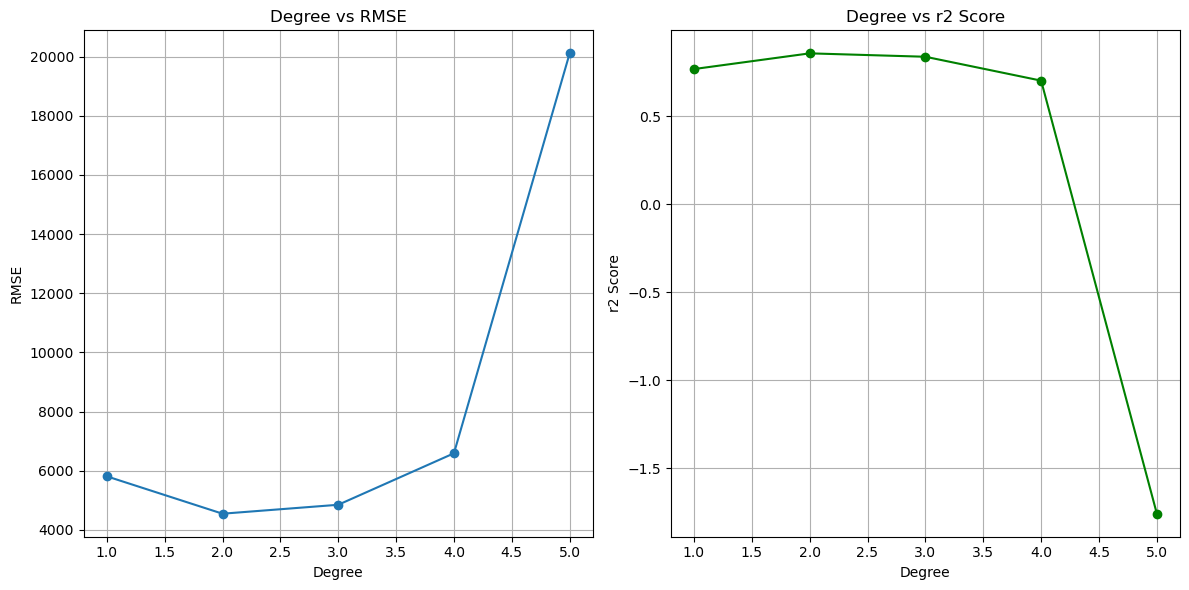

In [17]:
plt.figure(figsize=(12, 6))

# RMSE 그래프
plt.subplot(1, 2, 1)
plt.plot(result_df['degree'], result_df['RMSE'], marker='o')
plt.title('Degree vs RMSE')
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid(True)

# r2 그래프
plt.subplot(1, 2, 2)
plt.plot(result_df['degree'], result_df['R2'], marker='o', color='green')
plt.title('Degree vs r2 Score')
plt.xlabel('Degree')
plt.ylabel('r2 Score')
plt.grid(True)

plt.tight_layout()
plt.show()

In [20]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNet

alphas = [0.001, 0.01, 0.1, 1, 10, 100]
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train, y_train)
ridge_preds = ridge_cv.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_preds)
ridge_r2 = r2_score(y_test, ridge_preds)

print(f'ridge cv mse : {ridge_mse}, r2: {ridge_r2}')

ridge cv mse : 33812978.71880407, r2: 0.7693903609542041


In [21]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train, y_train)
lasso_preds = lasso_cv.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_preds)
lasso_r2 = r2_score(y_test, lasso_preds)

print(f'ridge cv mse : {lasso_mse}, r2: {lasso_r2}')

ridge cv mse : 34127013.26395648, r2: 0.7672485977659395


In [22]:
enet = ElasticNet(alpha=0.1, l1_ratio=0.5)
enet.fit(X_train, y_train)

ent_pred = enet.predict(X_test)
mse = mean_squared_error(y_test, ent_pred)
r2 = r2_score(y_test, ent_pred)

mse, r2

(np.float64(39739539.20991064), np.float64(0.7289703202650026))

In [25]:
results = pd.DataFrame(
    {
        '모델' : ['다항회귀', '릿지회귀', '라쏘회귀', '엘라스틱넷회귀'],
        'MSE' : [mean_squared_error(y_test, lr_pred_poly), 
                 mean_squared_error(y_test, ridge_preds),
                 mean_squared_error(y_test, lasso_preds),
                 mean_squared_error(y_test, ent_pred)],
        'R2' : [r2_score(y_test, lr_pred_poly), 
                 r2_score(y_test, ridge_preds),
                 r2_score(y_test, lasso_preds),
                 r2_score(y_test, ent_pred)]
    }
)

results

,모델,MSE,R2
0,다항회귀,2.068917e+07,0.858897
1,릿지회귀,3.381298e+07,0.769390
2,라쏘회귀,3.412701e+07,0.767249
3,엘라스틱넷회귀,3.973954e+07,0.728970
